Proyek Kedua: Membuat Model Machine Learning dengan Data Time Series
<br>Nama: Sheila Amalia Burhanudin
<br>Username: sheilaamalia
<br>Email: sheilaamalia85@gmail.com
<br>Dataset from Kaggle (https://www.kaggle.com/jaganadhg/house-hold-energy-data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
# import dataset House Hold Energy Data
df = pd.read_csv('/content/drive/MyDrive/Dataset/D202.csv')
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [3]:
print('Jumlah baris: ', df.shape[0])

Jumlah baris:  70368


In [4]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


Description of Data

**TYPE** - Tipe penggunaan listrik. Value untuk semua data adalah 'Electric Usage'
<br>**DATE** - Tanggal untuk konsumsi listrik
<br>**START TIME** - Waktu mulai untuk penggunaan listrik
<br>**END TIME** - Waktu berakhirnya penggunaan listrik
<br>**USAGE** - Jumlah penggunaan listrik dalam kWh
<br>**UNITS** - Unit pengukuran yang berisi 'kWh'
<br>**COST** - Tarif penggunaan listrik dalam satuan $.
<br>**NOTES** - Catatan (kosong)

In [5]:
# deskripsi dataset
df.describe()

,USAGE,NOTES
count,70368.000000,0.0
mean,0.121941,NaN
std,0.210507,NaN
min,0.000000,NaN
25%,0.030000,NaN
50%,0.050000,NaN
75%,0.120000,NaN
max,2.360000,NaN


In [6]:
# cek nilai null pada dataset
df.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [7]:
# menghapus kolom NOTES
df = df.drop('NOTES', axis=1)
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00


In [8]:
# membuat kolom baru DATE_TIME yang merupakan penggabungan dari kolom DATE dan END_TIME
import datetime
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df["END TIME"])
df.index = df["DATE_TIME"]

# resample data DATE_TIME menjadi per jam
df_hourly = df.resample('H').sum()
df_hourly.head()

,USAGE
DATE_TIME,
2016-10-22 00:00:00,0.04
2016-10-22 01:00:00,0.04
2016-10-22 02:00:00,0.08
2016-10-22 03:00:00,0.04
2016-10-22 04:00:00,0.04


In [9]:
# jumlah baris setelah resample
print('Jumlah baris df_hourly: ', df_hourly.shape[0])

Jumlah baris df_hourly:  17592


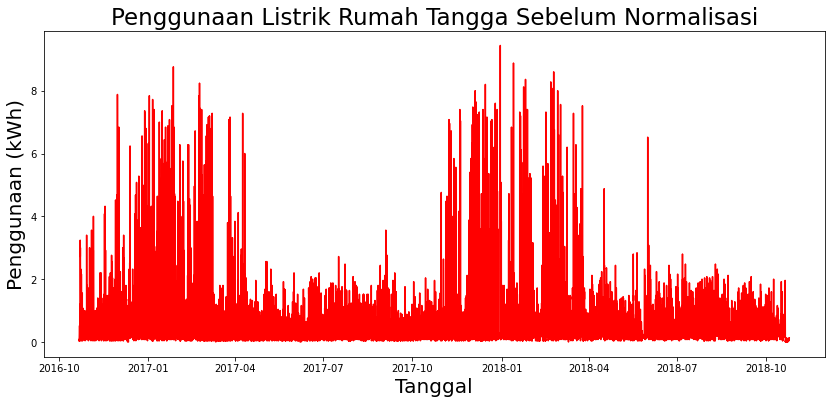

In [10]:
# plot data USAGE sebelum normalisasi data
plt.figure(figsize=(14,6))
plt.plot(df_hourly['USAGE'], label='Usage of Energy',color='red')
plt.xlabel('Tanggal',size=20)
plt.ylabel('Penggunaan (kWh)',size=20)
plt.title('Penggunaan Listrik Rumah Tangga Sebelum Normalisasi',size=23);

In [11]:
# normalisasi data dengan MinMaxScaler
ds = df_hourly.values
ds = ds.astype('float32')
ds = np.reshape(ds, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

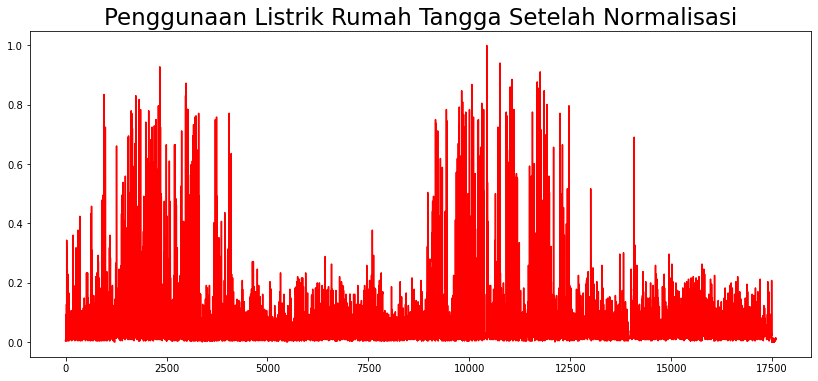

In [12]:
# tampilan plot visualisasi data setelah normalisasi
plt.figure(figsize=(14,6))
plt.plot(ds, label='Usage of Energy',color='red')
plt.title('Penggunaan Listrik Rumah Tangga Setelah Normalisasi',size=23);

In [13]:
#split data train (80%) dan test (20%)
train_size = int(len(ds) * 0.80)
test_size = len(ds) - train_size
train, test = ds[0:train_size,:], ds[train_size:len(ds),:]

In [14]:
# convert array menjadi matriks dataset
def create_dataset(ds, look_back=40):
    X, Y = [], []
    for i in range(len(ds)-look_back-1):
        a = ds[i:(i+look_back), 0]
        X.append(a)
        Y.append(ds[i + look_back, 0])
    return np.array(X), np.array(Y)

In [15]:
# reshape data X & Y
look_back = 40
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

print('Jumlah baris X_train: ', X_train.shape[0])
print('Jumlah baris Y_train: ', Y_train.shape[0])

Jumlah baris X_train:  14032
Jumlah baris Y_train:  14032


In [16]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [17]:
X_train.shape

(14032, 1, 40)

In [18]:
# arsitektur model
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

In [19]:
# training model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', optimizer=opt, metrics=['mae'])

history = model.fit(X_train, Y_train, epochs=40, batch_size=100, validation_data=(X_test, Y_test), 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)


model.summary()

Epoch 1/40
141/141 [==============================] - 22s 12ms/step - loss: 0.0475 - mae: 0.0475 - val_loss: 0.0240 - val_mae: 0.0240
Epoch 2/40
141/141 [==============================] - 1s 5ms/step - loss: 0.0446 - mae: 0.0446 - val_loss: 0.0233 - val_mae: 0.0233
Epoch 3/40
141/141 [==============================] - 1s 6ms/step - loss: 0.0437 - mae: 0.0437 - val_loss: 0.0228 - val_mae: 0.0228
Epoch 4/40
141/141 [==============================] - 1s 5ms/step - loss: 0.0431 - mae: 0.0431 - val_loss: 0.0224 - val_mae: 0.0224
Epoch 5/40
141/141 [==============================] - 1s 5ms/step - loss: 0.0429 - mae: 0.0429 - val_loss: 0.0221 - val_mae: 0.0221
Epoch 6/40
141/141 [==============================] - 1s 6ms/step - loss: 0.0422 - mae: 0.0422 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 7/40
141/141 [==============================] - 1s 5ms/step - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0215 - val_mae: 0.0215
Epoch 8/40
141/141 [==============================] - 1s 6ms/step - loss: 

In [20]:
# membuat prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# membalikkan nilai transformasi prediksi
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

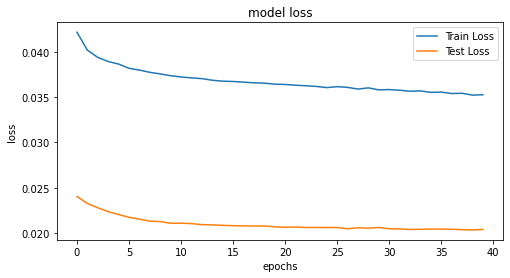

In [21]:
# plot perbandingan train loss dan test loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

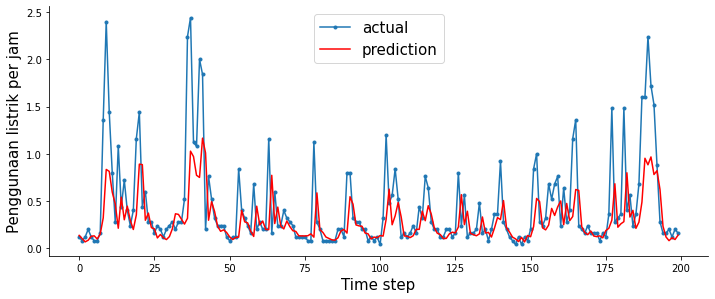

In [22]:
# plot perbandingan 200 data aktual dan data prediksi
import seaborn as sns
dt=[x for x in range(200)]
plt.figure(figsize=(10,4))
plt.plot(dt, Y_test[0][:200], marker='.', label="actual")
plt.plot(dt, test_predict[:,0][:200], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Penggunaan listrik per jam', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();